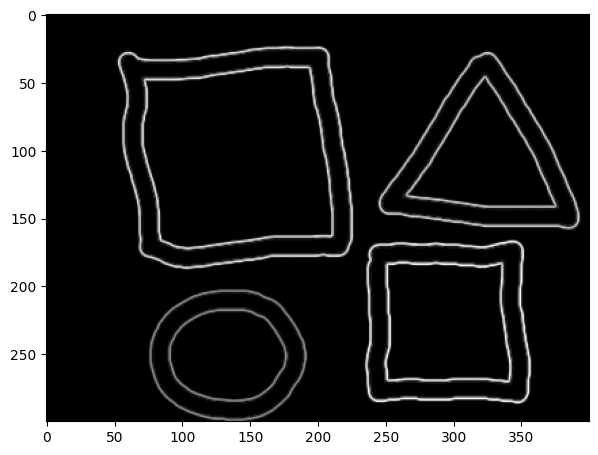

C:\Users\doanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\doanh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	std    	min    	max    
0  	0     	1738.57	303.774	1290.85	2295.04
1  	61    	4152.59	3687.16	1290.85	18646.8
2  	67    	3685.22	3147.16	1292.13	13645.2
3  	69    	3271.05	2655.39	1292.13	9077.4 
4  	72    	3059.03	2298.87	1292.13	9697.57
5  	62    	1492.49	724.534	1292.13	5110.78
6  	74    	1292.94	2.57894	1292.13	1304.93
7  	72    	1292.56	1.82917	1289.61	1302.22
8  	61    	1292.5 	2.3276 	1289.61	1308.31
9  	74    	1292.14	1.99413	1289.61	1302.09
10 	76    	1291.57	3.31381	1289.59	1309.57
11 	64    	1290.25	2.36502	1289.59	1304.17
12 	64    	1290.02	1.70742	1287.84	1299.56
13 	72    	1290.12	1.84927	1287.84	1297.75
14 	71    	1290.63	2.83142	1287.84	1300.64
15 	67    	1289.83	2.20179	1287.84	1299.54
16 	67    	1289.65	3.19734	1287.84	1305.27
17 	57    	1287.97	0.692918	1287.84	1292.5 
18 	59    	1288.33	2.012   	1287.84	1297.79
19 	80    	1288.44	2.15633 	1287.84	1297.85
20 	72    	1288.64	2.55274 	1287.84	1298.89
21 	77    	1288.7 	2.71187 	1287.84	1300.66
22 	66

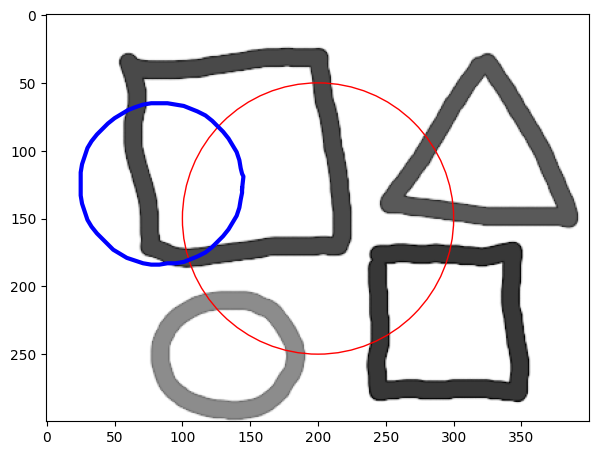

In [2]:
import random, math
import numpy as np
import skimage as skimage
import scipy as scipy
from skimage.color import rgb2gray
from skimage import data
from scipy import ndimage
from deap import creator, base, tools, algorithms

#% matplotlib
#inline

import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import cv2

alpha = 0.5  # controls continuity energy impact
beta =  0.9 # controls curvatur energy impact
gamma = 0.01  #controls area engery impact

delta = -1 #controls intensity energy impact
epsilon = 10 #controls gradient energy impact

imagepath = 'images/pic3.png'

image = cv2.imread(imagepath)

image = rgb2gray(image)

floatimage = skimage.img_as_float(image)

edgeImage = np.sqrt(scipy.ndimage.sobel(floatimage, axis=0, mode='reflect') ** 2 +
                    scipy.ndimage.sobel(floatimage, axis=1, mode='reflect') ** 2)
edgeImage = (edgeImage - edgeImage.min()) / (edgeImage.max() - edgeImage.min())

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(edgeImage, cmap=plt.cm.gray)

plt.show()

externalEnergy = delta * floatimage + epsilon * edgeImage

externalEnergyInterpolation = scipy.interpolate.RectBivariateSpline(np.arange(externalEnergy.shape[1]),
                                                                    np.arange(externalEnergy.shape[0]),
                                                                    externalEnergy.T, kx=3, ky=3, s=10)

def _externalEnergy(individual):
    x,y = individual[0][:,0], individual[0][:,1]
    energiesx = externalEnergyInterpolation(x,y,dx=1,grid=False)
    #energiesy = externalEnergyInterpolation(x,y,dy=1,grid=False)
    return (sum(energiesx))

def _areaEnergy(individual):
    A = 0.0
    for i in range(len(individual[0]) - 1):
        # x[i]* y[i+1] - x[i+1]*y[i]
        tmp_1 = individual[0][i][0] * individual[0][i + 1][1]
        tmp_2 = individual[0][i + 1][0] * individual[0][i][1]
        A = A + (tmp_1 - tmp_2)
    A = abs(A)
    return (0.5 * A)


def _continuityEnergy(individual):
    x,y = individual[0][:,0], individual[0][:,1]
    n = len(x)
    cE = 0.0
    for i in range(n-1):
        nextp = np.array((x[i+1],y[i+1]))
        currp = np.array((x[i],y[i]))
        cE = cE + np.linalg.norm(nextp - currp)**2
    return (cE)


def _smoothnessEnergy(individual):
    x,y = individual[0][:,0], individual[0][:,1]
    n = len(x)
    sE = 0.0
    for i in range(1,n-1):
        nextp = np.array((x[i+1],y[i+1]))
        currp = np.array((x[i],y[i]))
        prevp = np.array((x[i-1],y[i-1]))
        sE = sE + np.sum((nextp -2 * currp + prevp)**2)
    return (sE)


def eval(individual):
    sE = _smoothnessEnergy(individual)
    cE = _continuityEnergy(individual)
    aE = _areaEnergy(individual)
    eE = _externalEnergy(individual)   
    return (alpha * cE + beta * sE + gamma * aE + eE,)


def mutSet(prop, individual):
    size = len(individual[0])
    _x = random.randint(0, size - 1)
    _y = random.randint(0, 1)
    individual[0][_x][_y] += int(random.uniform(-2, 2))
    return individual,


def cxTwoPointCopy(ind1, ind2):
    # ind1 = ind1[0]
    # ind2 = ind2[0]
    size = len(ind1[0])
    cxpoint1 = random.randint(0, size - 1)
    cxpoint2 = random.randint(0, size - 2)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:  # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1
    ind1[0][cxpoint1:cxpoint2], ind2[0][cxpoint1:cxpoint2] \
        = ind2[0][cxpoint1:cxpoint2].copy(), ind1[0][cxpoint1:cxpoint2].copy()
    ind1.fitness.values = eval(ind1)
    ind2.fitness.values = eval(ind2)
    return ind1, ind2


def initIndividual():
    range_x = (80, 130)
    range_y = (100, 150)
    range_r = (60, 80)
    _x = random.randint(min(range_x), max(range_x))
    _y = random.randint(min(range_y), max(range_y))
    _r = random.randint(min(range_r), max(range_r))
    s = np.linspace(0, 2 * np.pi, 64)
    x = _x + _r * np.cos(s)  # 130 + 80 * np.cos(s)
    y = _y + _r * np.sin(s)  # 250 + 57 * np.sin(s)
    V = np.array([x, y]).T
    #V2 = V[::50]

    x0, y0 = V[:, 0].astype(int), V[:, 1].astype(int)

    # store snake progress
    sn = np.array([x0, y0]).T
    return sn


def genetic_algorithm():
    random.seed(64)
    # init:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    # register individuals
    toolbox.register("init_ind", initIndividual)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.init_ind, n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    # register crossover
    toolbox.register("mate", cxTwoPointCopy)
    toolbox.register("evaluate", eval)
    toolbox.register("mutate", mutSet, 0.2)
    toolbox.register("select", tools.selTournament, tournsize=5)
    #random.seed(64)

    # run GA
    pop = toolbox.population(n=100)

    for p in pop:
        p.fitness.values = eval(p)

    # Numpy equality function (operators.eq) between two arrays returns the
    # equality element wise, which raises an exception in the if similar()
    # check of the hall of fame. Using a different equality function like
    # numpy.array_equal or numpy.allclose solve this issue.
    hof = tools.HallOfFame(1, similar=np.array_equal)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.2, ngen=256, stats=stats, halloffame=hof)
    best = np.vstack([hof[0][0], hof[0][0][0]])

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(image, cmap=plt.cm.gray)
    circle1 = plt.Circle((200, 150), 100, color='r',fill=False)
    ax.add_artist(circle1)
    ax.plot(best[:, 0], best[:, 1], '-b', lw=3)

    plt.show()

    return pop, stats, hof


if __name__ == "__main__":
    genetic_algorithm()